<h1>
    Paches Loading From Whole slide images
</h1>

- This notebook is created to explore and check the correctness of patches loading from Whole Slide Images (WSIs).

### Necessary Packages

In [17]:
import sys
import torch
import os
import matplotlib.pyplot as plt
import dotenv
sys.path.append('../..')
from src.datasets import WSIPatchedDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torchvision.transforms import ToTensor,Compose,Resize,Lambda

### Load envirement variables

In [2]:
env = dotenv.find_dotenv()
WSI_FOLDER = dotenv.get_key(env, key_to_get="WSI_FOLDER")
print(WSI_FOLDER)

/home/abdelnour/Documents/4eme_anne/S2/projet/data/wsi


In [3]:
wsi_path = os.path.join(WSI_FOLDER, "train", "Group_AT", "Type_ADH", "BRACS_1003728.svs")
print(wsi_path)

/home/abdelnour/Documents/4eme_anne/S2/projet/data/wsi/train/Group_AT/Type_ADH/BRACS_1003728.svs


### Global

In [4]:
PATCH_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4
PREFETCH_FACTOR = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
print(DEVICE)

cuda


- We test the loading of the patches by calaculating the mean across the three channels and we arrange them according to position of their patches and it should
give us a mini version of the original WSI.

In [18]:
transform=Compose([
    Resize(size=(PATCH_SIZE,PATCH_SIZE)), # apply resizing for border patches
    ToTensor(), # convert to tensor
    Lambda(lambda x : x[:-1]) # remove the opacity
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
coords_path = "/home/abdelnour/Documents/4eme_anne/S2/projet/data/wsi_patches/patches/BRACS_1003728.h5"
dataset = WSIPatchedDataset(wsi_path=wsi_path,patch_size=PATCH_SIZE,transform=transform, coords_path=coords_path)
loader = DataLoader(dataset=dataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

In [20]:
print(len(dataset), dataset.width, dataset.height)

6717 587 298


In [21]:
def resize(loader : DataLoader) -> torch.Tensor:

    matrix = [[torch.zeros(3) for _ in range(loader.dataset.width)] for _ in range(loader.dataset.height)]

    for tiles, ws, hs in tqdm(loader):

        tiles = tiles.to(DEVICE)

        mean = tiles.mean(axis=-1).mean(axis=-1) 

        for i,(w, h) in enumerate(zip(ws,hs)):
            w = int(w // loader.dataset.patch_size)
            h = int(h // loader.dataset.patch_size)
            matrix[h][w] = mean[i].to('cpu')

    matrix = [torch.stack(row, dim=0) for row in matrix]
    matrix = torch.stack(matrix, dim=0)

    return matrix

In [24]:
resized_image = resize(loader=loader)

  0%|          | 0/210 [00:00<?, ?it/s]

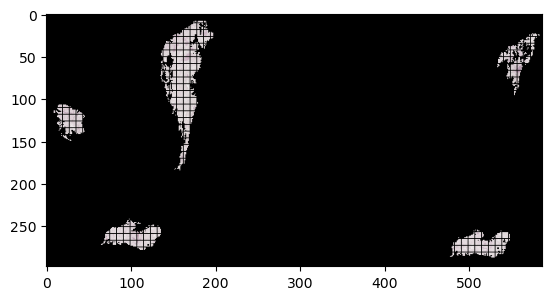

In [25]:
plt.imshow(resized_image)

- this exactly the generated stiches by CLAM, so we're loading the data right!.

In [1]:
import torch